## Wine Embeddings and a Wine Recommender

### 1. Introduction

In this notebook, we will combine a couple of best-practice approaches highlighted in the existing literature on this subject and create an embedding for each wine review. We will use this to build a simple wine recommender.

In [2]:
import pandas as pd 
import numpy as np

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

In [220]:
! pip install squarify
import squarify

### 1. The Raw Dataset

The official datasets : `winemag-data_first150k.csv` and `winemag-data-130k-v2.csv`

Our dataset : consists of roughly 180,000 wine reviews from www.winemag.com. These reviews span about 20 years and a 39 appelations. These reviews have been scraped one variety at a time, so the first step is to consolidate the various CSV files with the results of the scraping exercise.

In [6]:
path_corpus = '../../data_csv/'

df1 = pd.read_csv(path_corpus+'winemag-data_first150k.csv', sep=',', index_col=0)
df1

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...
150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


In [7]:
df2 = pd.read_csv(path_corpus+'winemag-data-130k-v2.csv', sep=',', index_col=0)
df2

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [19]:
df_all = pd.concat((df1, df2), axis=0)

df_all.drop_duplicates(subset=['description'], inplace=True)

df_all

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Pinot Noir,Citation,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon)
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Gewürztraminer,Domaine Gresser,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Pinot Gris,Domaine Marcel Deiss,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace)


In [20]:
df_all['Name'] = df_all['winery'] + ' ' + df_all['variety']  
df_all['Name'] 

0                                  Heitz Cabernet Sauvignon
1                     Bodega Carmen Rodríguez Tinta de Toro
2                                  Macauley Sauvignon Blanc
3                                          Ponzi Pinot Noir
4                   Domaine de la Bégude Provence red blend
                                ...                        
129966    Dr. H. Thanisch (Erben Müller-Burggraef) Riesling
129967                                  Citation Pinot Noir
129968                       Domaine Gresser Gewürztraminer
129969                      Domaine Marcel Deiss Pinot Gris
129970                      Domaine Schoffit Gewürztraminer
Name: Name, Length: 169430, dtype: object

In [22]:
df_all.drop_duplicates(subset=['Name'], inplace=True)

## Distribution of Wine Reviews by Top 20 Countries

Number of country list in data: 50


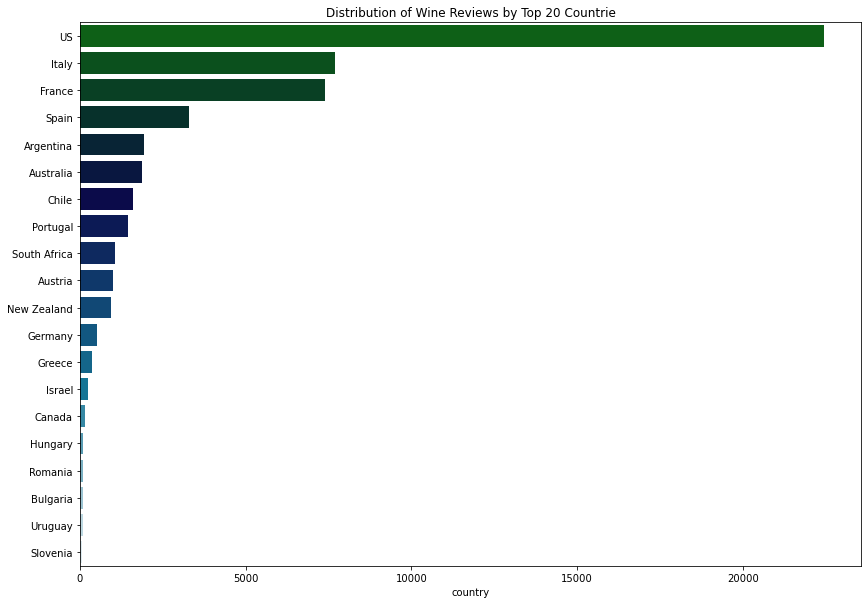

In [215]:
print('Number of country list in data:',df_all['country'].nunique())
plt.figure(figsize=(14,10))
cnt = df_all['country'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Countrie');

* Us contribute more in the review
* The wine review for 50 countries in the dataset
***
## Country wise average wine price

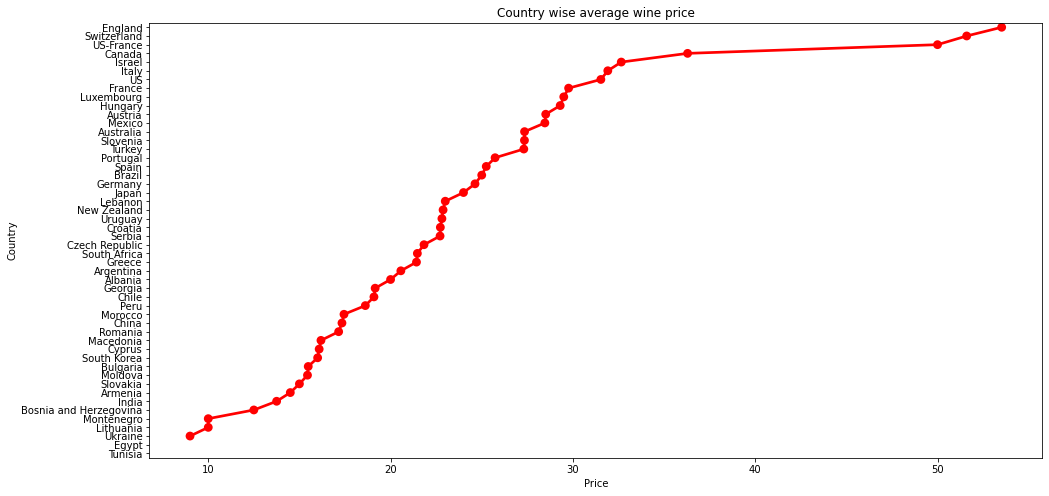

In [217]:
cnt = df_all.groupby(['country',]).mean()['price'].sort_values(ascending=False).to_frame()

plt.figure(figsize=(16,8))
sns.pointplot(x = cnt['price'] ,y = cnt.index ,color='r',orient='h',markers='o')
plt.title('Country wise average wine price')
plt.xlabel('Price')
plt.ylabel('Country');

### 2. Extracting Wine Descrpitors

To begin this analysis, we need to extract descriptors from our reviews and create a categorization of these descriptors at various levels of specificity. Here, I drew inspiration from some of the great work by Bernard Chen and others on the Computational Wine Wheel (https://www.springerprofessional.de/en/the-computational-wine-wheel-2-0-and-the-trimax-triclustering-in/10290536). 

Descriptors are extracted in a few steps, outlined in the cells below: first, all the wine reviews are conslidated into one large corpus. They are then tokenized into sentences.

In [24]:
df_all['description'].tolist()

['This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.',
 'Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.',
 'Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.',
 "This spent 20 months in 30% ne

In [42]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from nltk.tokenize import word_tokenize

In [ ]:
sno.stem('singers')

In [ ]:
raw_text = 'singers'

word_list = word_tokenize(raw_text)
normalized_sentence = []
for w in word_list:
    try:
        w = str(w)
        lower_case_word = str.lower(w)
        stemmed_word = sno.stem(lower_case_word)
        no_punctuation = stemmed_word.translate(punctuation_table)
        if len(no_punctuation) > 1 and no_punctuation not in stop_words:
            normalized_sentence.append(no_punctuation)
    except:
        continue

In [49]:
stop_words = set(stopwords.words('english'))

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def preprocessor_str(raw_text):
    """
    take the raw_text string, delete the stop words and stem every other words
    """
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return ' '.join(normalized_sentence)
    except:
        return ''


In [143]:
list_all = df_all['description'].tolist()
list_test = df_all['description'].tolist()[:5]
list_test

['This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.',
 'Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.',
 'Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.',
 "This spent 20 months in 30% ne

In [50]:
doc = 'This is the top wine from La Bégude, named after the highest point in the vineyard at 1200 feet. It has structure, density and considerable acidity that is still calming down. With 18 months in wood, the wine has developing an extra richness and concentration. Produced by the Tari family, formerly of Château Giscours in Margaux, it is a wine made for aging. Drink from 2020.'
preprocessor_str(doc)

'top wine la bégude name highest point vineyard 1200 feet structur densiti consider acid still calm 18 month wood wine develop extra rich concentr produc tari famili former château giscour margaux wine made age drink 2020'

Use sklearn to extract the features

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TODO

<5x142 sparse matrix of type '<class 'numpy.float64'>'
	with 174 stored elements in Compressed Sparse Row format>

Now for the most important part: leveraging existing wine theory, the work of others like Bernard Chen, wine descriptor mappings and the UC Davis wine wheel, the top 5000 most frequent wine terms were reviewed to (i) determine whether they are a descriptor that can be derived by blind tasting, and (ii) whether they are informative (judgments like 'tasty' and 'great' are not considered to be informative). The roughly 1000 descriptors that remain were then mapped onto a normalized descriptor, a category and a class:

In [52]:
descriptor_mapping = pd.read_csv('descriptor_mapping.csv').set_index('raw descriptor')
descriptor_mapping.head(10)

,level_3,level_2,level_1
raw descriptor,,,
abras,abrasive,high_tannin,tannin
acacia,acacia,flowery,flower
acacia_flower,acacia,flowery,flower
aciddriven,acid_driven,high_acid,acid
aggress,aggressive,high_acid,acid
airi,airy,light_bodied,body
allspic,allspice,baking_spices,spice
almond,almond,nutty,nutty
almond_past,almond,nutty,nutty


Next, any terms in the corpus that appear in the overview above are mapped onto the 'level_3' (the most specific) layer in the table.

In [66]:
def return_mapped_descriptor(word, level):
    """
    level = 1, 2 or 3
    """
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_%d'%level][word]
        return normalized_word
    else:
        return word
    
def preprocessor_str_with_mapped_descriptors(raw_text, level=3):
    """
    Same than preprocessor_str but return map_descriptor
    """
    # TODO

In [67]:
tfidf_mapped = TfidfVectorizer(preprocessor = lambda x: preprocessor_str_with_mapped_descriptors(x, 3)) 

X_mapped = tfidf_mapped.fit_transform(list_test)

### 3. From Wine Descriptors to Word Embeddings

We can now proceed to train a Word2Vec model on our normalized and descriptor-mapped corpus. This will allow us to get a word embedding for every term in the corpus. In order to reduce the overall size of the corpus, we will exclude any terms that appear fewer than 5 times across all the wine reviews.

In [56]:
from gensim.models import Word2Vec

In [57]:
wine_word2vec_model = Word2Vec.load("wine_word2vec_model.bin")
print(wine_word2vec_model)

Word2Vec(vocab=19924, vector_size=300, alpha=0.025)


You can also train with 

```python 
wine_word2vec_model = Word2Vec(normalized_sentences, size=300, min_count=5, iter=15)
```

Let's take a closer look at our trained Word2Vec model - what wine descriptors are most similar to the word 'peach'?

In [58]:
wine_word2vec_model.wv.most_similar(positive='peach', topn=10)

[('stone_fruit', 0.7766213417053223),
 ('honeydew', 0.7047279477119446),
 ('nectarine', 0.675035834312439),
 ('mango', 0.65788334608078),
 ('yellowpeach', 0.6536487340927124),
 ('pear', 0.6373700499534607),
 ('apple', 0.6313578486442566),
 ('tangerine', 0.6175214052200317),
 ('peach_papaya', 0.6129261255264282),
 ('kiwi', 0.6106383204460144)]

If you want to train it !  

In [97]:
wine_word2vec_model = Word2Vec(normalized_sentences, size=300, min_count=5, iter=15)
print(wine_word2vec_model)

wine_word2vec_model.save('wine_word2vec_model.bin')

Word2Vec(vocab=19924, size=300, alpha=0.025)


Are those words relatively similar to the word peach ? 

### 4. From Word Embeddings to Wine Review Embeddings

Now, we need to find a way to create a single embedding for each wine review, combining all the relevant word embeddings contained within it.

First, we will extract a set of mapped & normalized descriptors from each wine review. Unlike when we were training our Word2Vec model (when in-between words with semantic meaning could help create more accurate embeddings), we will remove any descriptors that do not feature in our list of 1000 curated descriptors. 

In [79]:
def return_only_mapped_descriptor(word, level):
    """
    Here don't return a word if its not in the descriptors of the wine wheel
    level = 1, 2 or 3
    """
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_%d'%level][word]
        return normalized_word
    
def preprocessor_str_with_mapped_descriptors_only(raw_text, level=3):
    """
    Same but than preprocessor_str but return ONLY the map_descriptors
    """
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    map_desc_only = return_only_mapped_descriptor(no_punctuation, level=level)
                    if map_desc_only:
                        normalized_sentence.append(map_desc_only)
            except:
                continue
        return ' '.join(normalized_sentence)
    except:
        return ''

In [ ]:
preprocessor_str_with_mapped_descriptors_only(doc, 3)

Create `X_mapped_only` using `TfidfVectorizer` and `preprocessor_str_with_mapped_descriptors_only`

In [144]:
# TODO

We are not using the same dataset so if we do not train the w2v it is normal to have a different vocabulary (because of `max_df=5000`)

In [96]:
import numpy as np

In [165]:
for wd, idx_wd in tfidf_mapped_only.vocabulary_.items():
    if wd not in wine_word2vec_model.wv.index_to_key:
        print(wd)     

foamy
raspy
off
light
boned
super_rich
frothy
over
oaked


Use `X_mapped_only` and `wine_word2vec_model` to create `X_wv` the matrix of the reviews embeddings

In [167]:
n_voc = len(tfidf_mapped_only.vocabulary_)
voc_w2v = wine_word2vec_model.wv.index_to_key

W2V = np.zeros((n_voc, 300))
for wd, idx_wd in tfidf_mapped_only.vocabulary_.items():
    if wd in voc_w2v:
        W2V[idx_wd] = wine_word2vec_model.wv[wd]

In [168]:
W2V.shape

(498, 300)

In [146]:
X_mapped_only.shape

(52873, 498)

In [ ]:
# TODO create X_wv

In [169]:
X_wv.shape

(52873, 300)

Not all descriptors are equally distinctive - 'fruity', for instance, is likely to appear very frequently across all wine reviews, whereas 'licorice' is much less common. In computing our 'review' embedding, we want to give a higher weighting to terms that are more infrequent in relative terms. We will do this by multiplying each word embedding by a TF-IDF (term frequency inverse document frequency) weighting. This takes into consideration both the frequency of each term across all reviews, as well as the number of descriptors in each wine review. 

In [ ]:
df_all['review_vector'] = list(np.asarray(X_wv))

In [313]:
df_all['descriptor_count'] = np.asarray(X_mapped_only>0).sum(axis=1)

In [402]:
df_all['descriptors'] = tfidf_mapped_only.inverse_transform(X_mapped_only)

In [406]:
df_all.reset_index(inplace=True, drop=True)
df_all

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title,Name,Variety_clean,review_vector,descriptor_count,Variety_common,descriptors
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN,Heitz Cabernet Sauvignon,Cabernet Sauvignon,"[-1.3533834838824892, -0.5121020850895461, 0.9...",7,Cabernet Sauvignon,"[caramel, cherry, elegant, fruit, juicy, mint,..."
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN,Bodega Carmen Rodríguez Tinta de Toro,NaN,"[-0.9235097061418167, 0.16486656236764752, 3.6...",14,NaN,"[baked, blackberry, cassis, chocolate, fig, fr..."
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN,Macauley Sauvignon Blanc,Sauvignon Blanc,"[-1.6927248318928454, 0.5990978036586903, 0.08...",11,Sauvignon Blanc,"[complex, compote, dark, gold, hazelnut, orang..."
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN,Ponzi Pinot Noir,Pinot Noir,"[-0.5981486348051956, -0.6610491304635047, 2.6...",12,Pinot Noir,"[blackberry, cherry, chocolate, cigar, coffee,..."
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN,Domaine de la Bégude Provence red blend,NaN,"[0.8759723599807496, 1.677615018376053, 2.3611...",4,NaN,"[concentrated, dense, rich, wood]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52868,US,Hailing from one of the more popular vineyards...,Jurassic Park Vineyard Old Vines,90,20.0,California,Santa Ynez Valley,Central Coast,Chenin Blanc,Birichino,Matt Kettmann,@mattkettmann,Birichino 2013 Jurassic Park Vineyard Old Vine...,Birichino Chenin Blanc,Chenin Blanc,"[-0.007417605129417991, 0.6794686685493116, -2...",11,Chenin Blanc,"[apple, bitter, chalk, cider, grapefruit, lemo..."
52869,US,This Zinfandel from the eastern section of Nap...,NaN,90,22.0,California,Chiles Valley,Napa,Zinfandel,Houdini,Virginie Boone,@vboone,Houdini 2011 Zinfandel (Chiles Valley),Houdini Zinfandel,Zinfandel,"[-1.6329673590721423, -0.9209375319450195, 0.5...",5,Zinfandel,"[bright, cinnamon, pepper, strawberry, white]"
52870,New Zealand,Roughly two-thirds Cabernet and one-third Merl...,Elspeth,90,25.0,Hawke's Bay,NaN,NaN,Cabernet Merlot,Mills Reef,Joe Czerwinski,@JoeCz,Mills Reef 2011 Elspeth Cabernet Merlot (Hawke...,Mills Reef Cabernet Merlot,NaN,"[-0.2880858513628346, -0.15507310371662786, 2....",7,NaN,"[cedar, cinnamon, fruit, medium_bodied, plum, ..."
52871,New Zealand,One of the more characterful Pinot Gris for th...,Single Estate,90,15.0,Marlborough,NaN,NaN,Pinot Gris,Ara,Joe Czerwinski,@JoeCz,Ara 2013 Single Estate Pinot Gris (Marlborough),Ara Pinot Gris,Pinot Gris,"[-0.9136338939047342, 1.7666919409814619, -0.7...",6,Pinot Gris,"[apple, cinnamon, cream, dust, pear, stone]"


To summarize, we generate a single vector for each wine review by going through the following steps:

1. Normalize words in wine review (remove stopwords, punctuation, stemming)
2. Enhance the set of normalized words with phrases (bi-grams and tri-grams)
3. Apply mapping of wine terms to each review, keeping only those mapped phrases & words that have been deemed relevant and mapping these to our curated level 3 descriptors
4. Retrieve the Word2Vec word embedding for each mapped term in the review
5. Weight each word embedding in the wine review with a TF-IDF weighting
6. Sum the word embeddings within each wine review to create a single vector representation of the wine review

### 5. Exploring our Wine Review Vectors

#### 5.1 Similarities Between Grape Varieties

Now that we have a vector representation of each wine review, we can start to explore potential uses of this data. Before we turn our attention to the creation of a wine recommendation engine, we will take a look at the similarities between grape varieties. We will do this by taking the average of all wine review vectors for each grape variety, compressing them into two dimensions using PCA (Principal Component Analysis) and then producing a visual mapping.

In [234]:
len(df_all.variety.unique())

757

In [239]:
(df_all.groupby('variety').points.count() > 200).sum()

41

In [240]:
df_all.groupby('variety').count().index[df_all.groupby('variety').points.count() > 200]

Index(['Albariño', 'Barbera', 'Bordeaux-style Red Blend',
       'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon',
       'Champagne Blend', 'Chardonnay', 'Chenin Blanc', 'Gamay',
       'Gewürztraminer', 'Glera', 'Grenache', 'Malbec', 'Merlot', 'Moscato',
       'Nebbiolo', 'Petit Verdot', 'Petite Sirah', 'Pinot Blanc',
       'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Portuguese Red',
       'Portuguese White', 'Red Blend', 'Rhône-style Red Blend',
       'Rhône-style White Blend', 'Riesling', 'Rosé', 'Sangiovese',
       'Sangiovese Grosso', 'Sauvignon Blanc', 'Shiraz', 'Sparkling Blend',
       'Syrah', 'Tempranillo', 'Tempranillo Blend', 'Viognier', 'White Blend',
       'Zinfandel'],
      dtype='object', name='variety')

Let's take the wine types appearing at least 200 times 

In [251]:
threshold_variety = 200

list_most_common_wines = df_all.groupby('variety').count().index[df_all.groupby('variety').points.count() > threshold_variety]
list_most_common_wines

Index(['Albariño', 'Barbera', 'Bordeaux-style Red Blend',
       'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon',
       'Champagne Blend', 'Chardonnay', 'Chenin Blanc', 'Gamay',
       'Gewürztraminer', 'Glera', 'Grenache', 'Malbec', 'Merlot', 'Moscato',
       'Nebbiolo', 'Petit Verdot', 'Petite Sirah', 'Pinot Blanc',
       'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Portuguese Red',
       'Portuguese White', 'Red Blend', 'Rhône-style Red Blend',
       'Rhône-style White Blend', 'Riesling', 'Rosé', 'Sangiovese',
       'Sangiovese Grosso', 'Sauvignon Blanc', 'Shiraz', 'Sparkling Blend',
       'Syrah', 'Tempranillo', 'Tempranillo Blend', 'Viognier', 'White Blend',
       'Zinfandel'],
      dtype='object', name='variety')

In [253]:
variety_mapping = {'Shiraz': 'Syrah', 'Pinot Grigio': 'Pinot Gris', 'Pinot Grigio/Gris': 'Pinot Gris', 
                   'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache'}

for wine in list_most_common_wines:
    if wine not in variety_mapping:
        variety_mapping[wine] = wine
variety_mapping

{'Shiraz': 'Syrah',
 'Pinot Grigio': 'Pinot Gris',
 'Pinot Grigio/Gris': 'Pinot Gris',
 'Garnacha, Grenache': 'Grenache',
 'Garnacha': 'Grenache',
 'Albariño': 'Albariño',
 'Barbera': 'Barbera',
 'Bordeaux-style Red Blend': 'Bordeaux-style Red Blend',
 'Bordeaux-style White Blend': 'Bordeaux-style White Blend',
 'Cabernet Franc': 'Cabernet Franc',
 'Cabernet Sauvignon': 'Cabernet Sauvignon',
 'Champagne Blend': 'Champagne Blend',
 'Chardonnay': 'Chardonnay',
 'Chenin Blanc': 'Chenin Blanc',
 'Gamay': 'Gamay',
 'Gewürztraminer': 'Gewürztraminer',
 'Glera': 'Glera',
 'Grenache': 'Grenache',
 'Malbec': 'Malbec',
 'Merlot': 'Merlot',
 'Moscato': 'Moscato',
 'Nebbiolo': 'Nebbiolo',
 'Petit Verdot': 'Petit Verdot',
 'Petite Sirah': 'Petite Sirah',
 'Pinot Blanc': 'Pinot Blanc',
 'Pinot Gris': 'Pinot Gris',
 'Pinot Noir': 'Pinot Noir',
 'Portuguese Red': 'Portuguese Red',
 'Portuguese White': 'Portuguese White',
 'Red Blend': 'Red Blend',
 'Rhône-style Red Blend': 'Rhône-style Red Blend',
 'R

In [316]:
df_all['Variety_common'] = df_all['variety'].map(variety_mapping)

In [260]:
df_all.Variety_clean.notnull().mean()

0.8067444631475422

We have 80% of the wine of the dataset 
***

In [275]:
from sklearn.decomposition import PCA

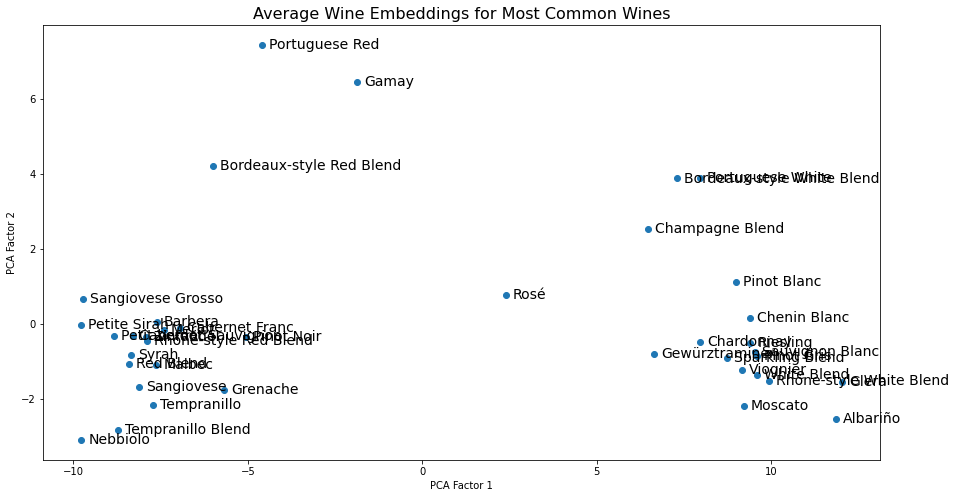

In [301]:
wine_reviews_clean = df_all[df_all.Variety_common.notnull()]

def subset_wine_vectors(wine_reviews_clean, list_of_varieties):
    """
    Subset of the wines
    """
    if not list_of_varieties:
        list_of_varieties = wine_reviews_clean.Variety_clean.unique()
        
    wine_variety_vectors = []
    for v in list_of_varieties:
        one_var_only = wine_reviews_clean.loc[wine_reviews_clean['Variety_clean'] == v]
        # if this variety exists 
        if len(one_var_only):
            review_arrays = one_var_only['review_vector']
            average_variety_vec = np.average(review_arrays)
            wine_variety_vector = [v, average_variety_vec]
            wine_variety_vectors.append(wine_variety_vector)
    return wine_variety_vectors

def pca_wine_variety(wine_reviews_clean, list_of_varieties=None):
    wine_var_vectors = subset_wine_vectors(wine_reviews_clean, list_of_varieties)
    pca = PCA(n_components=2)
    # pca.fit([w[1] for w in wine_var_vectors])  
    pca_dataset = pca.fit_transform([w[1] for w in wine_var_vectors])
    pca_dataframe = pd.DataFrame(pca_dataset, columns=['pca_1', 'pca_2'])
    pca_dataframe.index = [w[0] for w in wine_var_vectors]
    # print(pca_dataframe)
    return pca_dataframe

pca_w_dataframe = pca_wine_variety(wine_reviews_clean=wine_reviews_clean, list_of_varieties = None)

plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=14)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common Wines', fontsize=16)
plt.show()

Test avec les reviews qui ont le plus de descripteurs

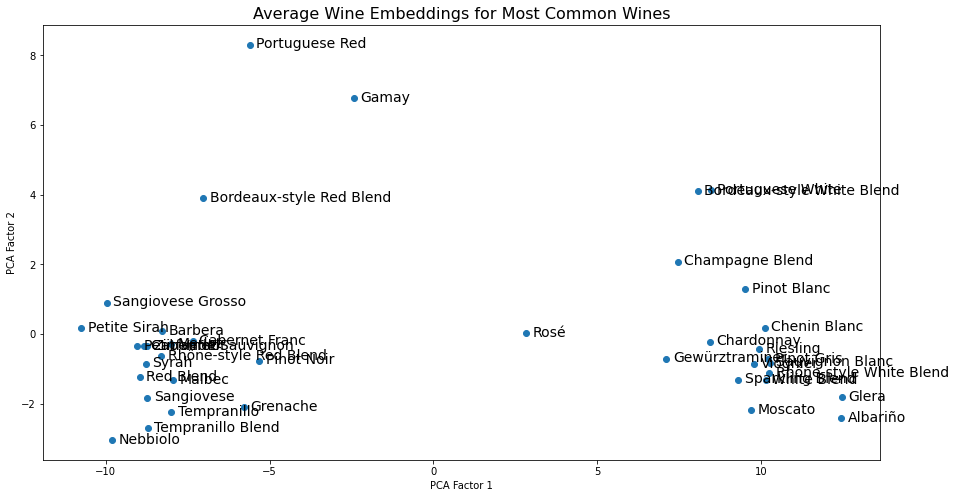

In [317]:
wine_reviews_clean = df_all[df_all.Variety_common.notnull()]
pca_w_dataframe = pca_wine_variety(wine_reviews_clean=wine_reviews_clean[wine_reviews_clean.descriptor_count > 5], 
                                   list_of_varieties = None)

plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=14)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common Wines', fontsize=16)
plt.show()

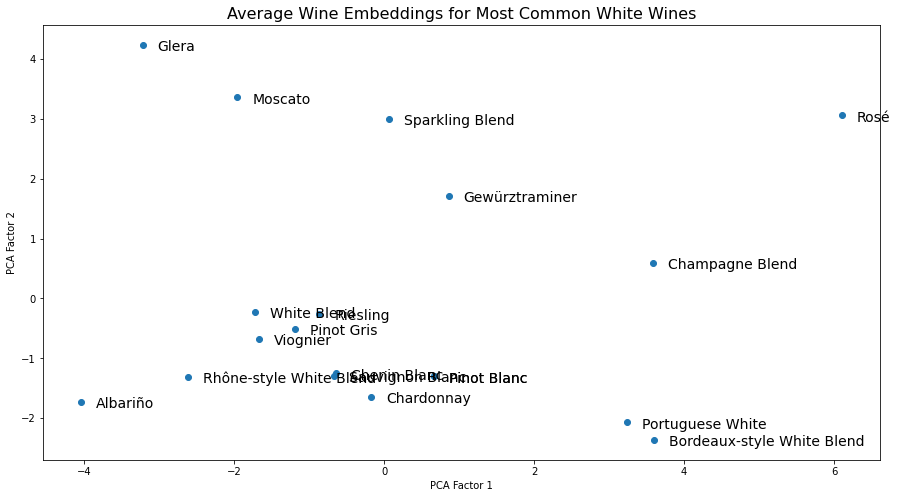

In [321]:
most_common_whites = ['Bordeaux-style White Blend', 'Rhône-style White Blend', 'Portuguese White', 'Pinot Blanc', 
                    'Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Gris', 'White Blend', 'Sparkling Blend', 
                      'Champagne Blend', 'Gruner Veltliner', 'Viognier', 'Chenin Blanc', 'Albariño', 'Pinot Blanc', 'Verdejo',
                    'Torrontes', 'Vermentino', 'Melon', 'Gewürztraminer', 'Rhone-style White Blend', 'Rosé', 
                      'Moscato', 'Glera']

pca_w_dataframe = pca_wine_variety(wine_reviews_clean=wine_reviews_clean, list_of_varieties = most_common_whites)

plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=14)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common White Wines', fontsize=16)
plt.show()

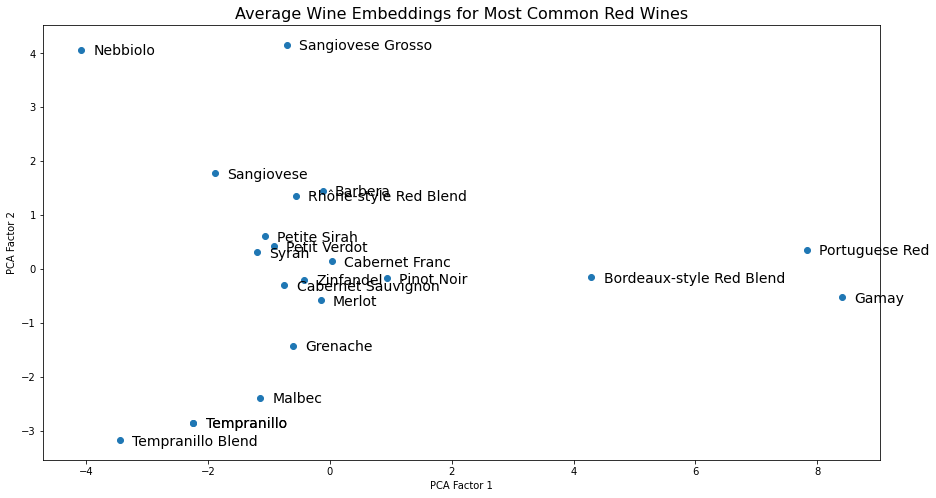

In [306]:
most_common_reds = ['Bordeaux-style Red Blend', 'Rhône-style Red Blend', 'Portuguese Red', 'Pinot Noir', 
                    'Cabernet Sauvignon', 'Syrah', 'Merlot', 'Sangiovese', 'Zinfandel', 'Tempranillo', 
                   'Nebbiolo', 'Malbec', 'Grenache', 'Sangiovese Grosso', 'Petit Verdot', 
                         'Cabernet Franc', 'Gamay','Tempranillo Blend', 'Tempranillo', 'Petite Sirah',
                        'Barbera', "Nero d'Avola", "Italian Red", 
                    #'Glera',
                   ]
                   
       

pca_w_dataframe = pca_wine_variety(wine_reviews_clean=wine_reviews_clean, list_of_varieties = most_common_reds)

plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=14)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common Red Wines', fontsize=16)
plt.show()

#### 5.2 Wine Recommender

We can also use our wine review vectors to make wine suggestions. We can do this by using a nearest neighbors model, which calculates the cosine distance between various wine review vectors. The vectorized wine reviews that lie closest to one another are returned as suggestions.

In [322]:
wine_reviews_mincount = df_all[df_all.descriptor_count > 5].copy()

wine_reviews_mincount.Name

0                     Heitz Cabernet Sauvignon
1        Bodega Carmen Rodríguez Tinta de Toro
2                     Macauley Sauvignon Blanc
3                             Ponzi Pinot Noir
5                      Numanthia Tinta de Toro
                         ...                  
52867                     Paraduxx White Blend
52868                   Birichino Chenin Blanc
52870               Mills Reef Cabernet Merlot
52871                           Ara Pinot Gris
52872                             COS Frappato
Name: Name, Length: 43772, dtype: object

In [324]:
from sklearn.neighbors import NearestNeighbors

Implement a KNN on the embeddings

In [329]:
input_vectors = list(wine_reviews_mincount['review_vector'])
input_vectors_listed = [a.tolist() for a in input_vectors]

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric='cosine')
model_knn = knn.fit(input_vectors_listed)

In [399]:
name_test = "Ara 2013 Single Estate Pinot Gris (Marlborough)"
#name_test = "Birichino 2013 Jurassic Park Vineyard Old Vines Chenin Blanc (Santa Ynez Valley)"
#name_test = "Clay Pigeon 2013 Pinot Noir (Willamette Valley)"

wine_test_vector = wine_reviews_mincount.loc[wine_reviews_mincount['title'] == name_test]['review_vector'].tolist()[0]
distance, indice = model_knn.kneighbors(wine_test_vector.reshape(1, -1), n_neighbors=6)
distance_list = distance[0].tolist()[1:]
indice_list = indice[0].tolist()[1:]

main_wine = wine_reviews_mincount.loc[wine_reviews_mincount['title'] == name_test]

print('Wine to match:', name_test)
print('The original wine has the following descriptors:', 
      list(tfidf_mapped_only.inverse_transform(X_mapped_only[main_wine.index[0]])[0]))
print('_________')


def return_wine_name(wine_reviews_mincount, i):
    """
    Return the wine's name 
    Can be using the title, designation or Name columns
    """
    # TODO
    wine_name = None
    return wine_name

n = 1
for d, i in zip(distance_list, indice_list):
    # TODO
    print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
    print('This wine has the following descriptors:', wine_descriptors)
    print('')
    n+=1

Wine to match: Ara 2013 Single Estate Pinot Gris (Marlborough)
The original wine has the following descriptors: ['apple', 'cinnamon', 'cream', 'dust', 'pear', 'stone']
_________
Suggestion 1 : Prosecco Brut Kosher with a cosine distance of 0.094
This wine has the following descriptors: [array(['apple', 'cinnamon', 'clean', 'cream', 'fresh', 'lime', 'pear',
       'rich', 'slate', 'vanilla'], dtype='<U18')]

Suggestion 2 : Shirley Mays with a cosine distance of 0.095
This wine has the following descriptors: [array(['apple', 'cinnamon', 'dust', 'fruit', 'light_bodied', 'pear',
       'toast', 'yeast'], dtype='<U18')]

Suggestion 3 : Grotte with a cosine distance of 0.099
This wine has the following descriptors: [array(['apple', 'cream', 'flower', 'fruit', 'herb', 'juicy', 'minerality',
       'peach', 'pear', 'stone', 'white'], dtype='<U18')]

Suggestion 4 : Nine Hats Pinot Gris with a cosine distance of 0.104
This wine has the following descriptors: [array(['apple', 'cinnamon', 'dust', 

Finally, we can also use our wine recommender model to return a suggestion for a wine based on a list of input descriptors. This could be helpful when looking for similarities between wines, or when searching for a particular flavor profile.

In [400]:
dict_of_tfidf_weightings = dict(zip(tfidf_mapped_only.get_feature_names(), tfidf_mapped_only.idf_))


def descriptors_to_best_match_wines(list_of_descriptors, number_of_suggestions=10):
    weighted_review_terms = []
    for term in list_of_descriptors:
        if term not in dict_of_tfidf_weightings:
            if term not in descriptor_mapping.index:
                print('choose a different descriptor from', term)
                continue
            else:
                term = descriptor_mapping['normalized'][term]
        tfidf_weighting = dict_of_tfidf_weightings[term]
        word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
        weighted_word_vector = tfidf_weighting * word_vector
        weighted_review_terms.append(weighted_word_vector)
    review_vector = sum(weighted_review_terms)
    
    distance, indice = model_knn.kneighbors(review_vector, n_neighbors=number_of_suggestions+1)
    distance_list = distance[0].tolist()[1:]
    indice_list = indice[0].tolist()[1:]

    n = 1
    for d, i in zip(distance_list, indice_list):
        # wine_name = wine_reviews_mincount['Name'][i]
        wine_name = return_wine_name(wine_reviews_mincount, i)
        
        idx_ini = wine_reviews_mincount.iloc[i].name
        wine_descriptors = tfidf_mapped_only.inverse_transform(X_mapped_only[idx_ini])
        
        print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
        print('This wine has the following descriptors:', wine_descriptors)
        print('')
        n+=1
    
descriptors = ['complex', 'high_acid', 'fresh', 'grass', 'lime']
descriptors_to_best_match_wines(list_of_descriptors=descriptors, number_of_suggestions=5)

Suggestion 1 : Blanc de Blancs Brut Reserva with a cosine distance of 0.140
This wine has the following descriptors: [array(['apple', 'cider', 'citrus', 'complex', 'flower', 'green', 'herb',
       'juicy', 'lean', 'lime', 'racy', 'zesty'], dtype='<U18')]

Suggestion 2 : Lasalde Elkartea 2015 Txakoli Aitzalde Hondarrabi Zuri (Getariako Txakolina) with a cosine distance of 0.145
This wine has the following descriptors: [array(['celery', 'citrus', 'fresh', 'gooseberry', 'grass', 'juicy',
       'lemon', 'snappy', 'tart'], dtype='<U18')]

Suggestion 3 : Alessandro di Camporeale 2013 Kaid Sauvignon (Sicilia) with a cosine distance of 0.151
This wine has the following descriptors: [array(['firm', 'fresh', 'fruit', 'grapefruit', 'grass', 'herb', 'lime',
       'zesty'], dtype='<U18')]

Suggestion 4 : Mania Verdejo with a cosine distance of 0.152
This wine has the following descriptors: [array(['citrus', 'fruit', 'grass', 'light_bodied', 'lime', 'pepper',
       'pineapple', 'pungent', 'tangy

#### 5.3 Try comparing with simple TF-IDF vectors not using word2vec   

In [2]:
# TODO

#### 5.4 Wine Recommender in a Chatbot 

Ask questions to a user in order to collect information about his/her tastes and match it with the descriptors 

In [ ]:
# TODO

#### 6. Conclusion

This notebook is an exercise in two parts. In the first part, we develop a robust method to generate a 'wine embedding' that captures all relevant information from a wine review, maps it onto a set of curated and standardized descriptors, assigns an embedding to each of these descriptors, weights each descriptor using a TF-IDF score and then aggregates the various descriptor vectors to produce a single 'wine embedding' for the full wine review. In the second part of this notebook, we start to explore ways in which we might use these newly created wine embeddings. One way to do this is through a wine recommender model, which measures the cosine distance between wine embeddings to make suggestions. Based on a few examples, we can see that the suggestions that are returned are remarkably consistent. This is a promising result that suggests there is much potential for wine embeddings to be used for future iterations of this work.